### Import Required Libraries

In [0]:
import string
import re
from numpy import array, argmax, random, take, delete
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [111]:
pip install numpy

### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [0]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [0]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [0]:
data = read_text("./drive/My Drive/Traductor/spa.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [0]:
deu_eng = deu_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [118]:
deu_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Fatigue showed on her face.', 'Su cara mostraba fatiga.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['Few students knew his name.',
        'Pocos estudiantes conocían su nombre.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['Fill out the questionnaire.', 'Rellena el cuestionario.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [0]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [120]:
deu_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Fatigue showed on her face', 'Su cara mostraba fatiga',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['Few students knew his name',
        'Pocos estudiantes conocían su nombre',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['Fill out the questionnaire', 'Rellena el cuestionario',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

In [0]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [196]:
deu_eng

array([['go', 've',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['go', 'vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['go', 'vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['fatigue showed on her face', 'su cara mostraba fatiga',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['few students knew his name',
        'pocos estudiantes conocían su nombre',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['fill out the questionnaire', 'rellena el cuestionario',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [126]:
print(deu_eng[:,0], deu_eng[:,1])


['go' 'go' 'go' ... 'fatigue showed on her face'
 'few students knew his name' 'fill out the questionnaire'] ['ve' 'vete' 'vaya' ... 'su cara mostraba fatiga'
 'pocos estudiantes conocían su nombre' 'rellena el cuestionario']


In [0]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [0]:
#mio = Quedarme solo con las senteces con longitud menor o igual a 5
spa = []
engnew= []

for position, sentence in enumerate(deu_eng[:,0]):
  if(len(sentence.split()) <=5 and len(engnew) < 43585):
    engnew.append(sentence)
   

for position, sentence in enumerate(deu_eng[:,1]):
  if(len(sentence.split()) <=5):
    spa.append(sentence)

In [0]:
#miooooooo
# empty lists
english_len = []
spanish_len = []

# populate the lists with sentence lengths
for i in engnew:
    english_len.append(len(i.split()))

for i in spa:
    spanish_len.append(len(i.split()))

In [235]:
#miooooo
print(len(english_len))
print(len(spanish_len))

43585


In [218]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.deu))
#mio
length_df_new = pd.DataFrame({'spa':spanish_len, 'engnew':english_len})
print(length_df_new)
print(max(length_df_new.spa))
print(max(length_df_new.engnew))

       eng  deu
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    4    4
49996    6    6
49997    5    4
49998    5    5
49999    4    3

[50000 rows x 2 columns]
8
12
       spa  engnew
0        1       1
1        1       1
2        1       1
3        1       1
4        1       1
...    ...     ...
43580    4       5
43581    4       5
43582    4       5
43583    5       5
43584    3       4

[43585 rows x 2 columns]
5
5


In [219]:
#mioo --> comprobamos que ssolo tenemos sentences con longitud 5
length_df_new.hist(bins = 30)
plt.show()

In [220]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [222]:
# prepare english tokenizer
engnew_tokenizer = tokenization(engnew)
engnew_vocab_size = len(engnew_tokenizer.word_index) + 1

engnew_length = 5
print('English Vocabulary Size: %d' % engnew_vocab_size)

English Vocabulary Size: 6635


In [224]:
# prepare Deutch tokenizer
spa_tokenizer = tokenization(spa)
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 5
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 13288


In [225]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 103), ('vete', 29), ('vaya', 27), ('váyase', 7), ('hola', 12), ('¡corre', 1), ('¡corran', 1), ('¡corra', 1), ('¡corred', 1), ('corred', 1), ('¿quién', 343), ('¡órale', 10), ('¡fuego', 4), ('¡incendio', 1), ('¡disparad', 3), ('¡ayuda', 2), ('¡socorro', 1), ('¡auxilio', 2), ('¡salta', 1), ('salte', 2), ('¡parad', 1), ('¡para', 4), ('¡pare', 1), ('¡espera', 4), ('esperen', 10), ('continúa', 14), ('continúe', 6), ('me', 2448), ('oculté', 1), ('escondí', 1), ('ocultaba', 1), ('escondía', 1), ('corrí', 10), ('corría', 4), ('lo', 1584), ('intento', 8), ('¡he', 2), ('ganado', 13), ('¡oh', 3), ('no', 4806), ('tomátelo', 2), ('con', 616), ('soda', 3), ('¡disparen', 1), ('¡dispara', 1), ('¡dispará', 1), ('¡dispare', 1), ('sonríe', 5), ('¡al', 2), ('ataque', 3), ('¡atacad', 1), ('¡ataque', 1), ('¡ataquen', 1), ('¡ataca', 1), ('levanta', 17), ('ahora', 438), ('mismo', 101), ('id', 7), ('vayan', 10), ('ya', 302), ('¡lo', 10), ('tengo', 773), ('¿lo', 63), ('pillas', 1), ('¿entendi

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [228]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(engnew_tokenizer, engnew_length, train[:, 0])

[[   2 1430  216    4   44]
 [  15  763    6 1802 3061]
 [ 485   13   10   96  217]
 ...
 [   7 3078    8  762    0]
 [  13   46  283   10 1842]
 [  76  396  269    0    0]]
40000
[[   3  488   72   35    0]
 [   9  294   41 1071 1019]
 [  19   64   24    2   56]
 ...
 [   2  294   13  761    0]
 [ 277  766  277    2   28]
 [   1   56    7  286   83]]
40000


In [229]:
print(trainX.shape)
print(trainY.shape)

(40000, 5)
(40000, 5)


In [230]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(engnew_tokenizer, engnew_length, test[:, 0])

[[1021   79 1149   24    0]
 [  23  101   26    0    0]
 [  64   18  785    0    0]
 ...
 [1088  191   28 3619    0]
 [  36  296    6  961    0]
 [   3  261  143  125    0]]
10000
[[  84   57   31   10  310]
 [   1  123   32    0    0]
 [  68  492    2    0    0]
 ...
 [  18    2   25 2228    0]
 [   2   19  655  927    0]
 [   9    4  228    7   47]]
10000


In [231]:
print(testX.shape)
print(testY.shape)

(10000, 5)
(10000, 5)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(SimpleRNN(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(SimpleRNN(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(GRU(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(GRU(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [254]:
print(spa_vocab_size)
print(engnew_vocab_size)
print(spa_length)
print(engnew_length)

13288
6635
5
5


In [0]:
model = build_model(spa_vocab_size, engnew_vocab_size, spa_length, engnew_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [256]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 6s 178us/step - loss: 5.5110 - val_loss: 5.0980

Epoch 00001: val_loss improved from inf to 5.09803, saving model to model.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 5s 142us/step - loss: 4.9667 - val_loss: 4.9746

Epoch 00002: val_loss improved from 5.09803 to 4.97458, saving model to model.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 4s 139us/step - loss: 4.7423 - val_loss: 4.8076

Epoch 00003: val_loss improved from 4.97458 to 4.80761, saving model to model.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 5s 142us/step - loss: 4.5045 - val_loss: 4.5670

Epoch 00004: val_loss improved from 4.80761 to 4.56703, saving model to model.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 5s 146us/step - loss: 4.2629 - val_loss: 4.3817

Epoch 00005: val_loss improved from 4.56703 to 4.38170, 

Let's compare the training loss and the validation loss.

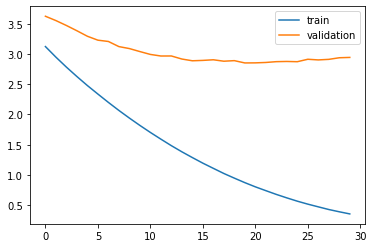

In [236]:
#LSTM
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

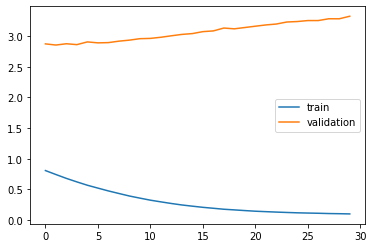

In [252]:
#simpleRNN
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

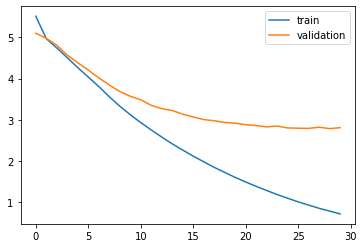

In [257]:
#GRU --> Como requiere menos memoria funciona mejor que LSTM
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [237]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

In [242]:
pred_df.head(15)

actual              predicted
0      so how did this happen  when did this  happen
1                  i eat here        i talked here  
2              who helped you       who helped you  
3              smoke appeared    he looked there up 
4    they went to new zealand       they us with  us
5    can you explain it to me     you explain it  me
6   four times five is twenty    four times five is 
7    i just wanted to see you      i just to see you
8           im a little crazy             im a  bit 
9     im sorry for what i did      sorry  what i did
10              hes too drunk         its too very  
11                 tom saw me          tom saw him  
12              tom was dying     tom was prepared  
13              this is weird        this is harsh  
14           lets hit the hay           lets go to

In [243]:
pred_df.tail(15)

actual              predicted
9985      you really are nuts        im doing im am 
9986        they kept running      they ran closer  
9987    all of these are mine     most are mine are 
9988     youve come too early     you get too early 
9989      nobody can stop tom   nobody cant stop us 
9990      i dont mind waiting        i wont get  yet
9991       happy thanksgiving              two   of 
9992              i loved her           i loved it  
9993  did you come here alone    have you live here 
9994          were surrounded      theyre arguing   
9995    i was very busy today  i was very busy today
9996    i used to be your age    used to be your age
9997       do you like robots    do you like robots 
9998  you have until midnight   he has ten midnight 
9999     he is hard to please     it happy to happy

In [244]:
pred_df.tail(15)

actual              predicted
9985      you really are nuts        im doing im am 
9986        they kept running      they ran closer  
9987    all of these are mine     most are mine are 
9988     youve come too early     you get too early 
9989      nobody can stop tom   nobody cant stop us 
9990      i dont mind waiting        i wont get  yet
9991       happy thanksgiving              two   of 
9992              i loved her           i loved it  
9993  did you come here alone    have you live here 
9994          were surrounded      theyre arguing   
9995    i was very busy today  i was very busy today
9996    i used to be your age    used to be your age
9997       do you like robots    do you like robots 
9998  you have until midnight   he has ten midnight 
9999     he is hard to please     it happy to happy

In [245]:
pred_df.sample(15)

actual              predicted
5980      are you getting bored        are you bored  
4517    you are only young once            hes is at  
3802     what does the cat want        what does buy  
3094           she is not young         she is young  
6133               you promised        you promised   
719                    humor me             please    
9513          im a photographer                im a   
7528         i told him to come         told  to  come
484      lets try one more time    lets try once more 
7690               i feel faint           i feel fat  
7157       what does tom do now      what did tom now 
6857   she bowed to me politely           he left  at 
9896          i sat on the curb  sat down by the bench
6198        tom was out all day        he was all  day
689   we are brother and sister         im am of girl